<a href="https://colab.research.google.com/github/yusufboran/dasboard-project/blob/main/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [2]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-10-30 08:27:28--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-10-30 08:27:28 (42.4 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

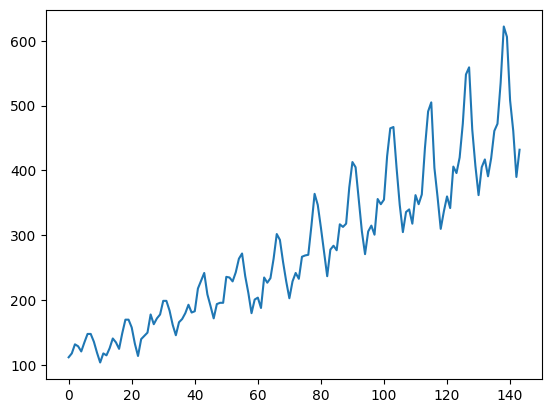

In [5]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [19]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 5
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [23]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.03546
Epoch: 100, loss: 0.00471
Epoch: 200, loss: 0.00364
Epoch: 300, loss: 0.00274
Epoch: 400, loss: 0.00230
Epoch: 500, loss: 0.00215
Epoch: 600, loss: 0.00210
Epoch: 700, loss: 0.00206
Epoch: 800, loss: 0.00245
Epoch: 900, loss: 0.00204
Epoch: 1000, loss: 0.00203
Epoch: 1100, loss: 0.00203
Epoch: 1200, loss: 0.00202
Epoch: 1300, loss: 0.00202
Epoch: 1400, loss: 0.00201
Epoch: 1500, loss: 0.00201
Epoch: 1600, loss: 0.00200
Epoch: 1700, loss: 0.00200
Epoch: 1800, loss: 0.00200
Epoch: 1900, loss: 0.00199


## Testing for Airplane Passengers Dataset

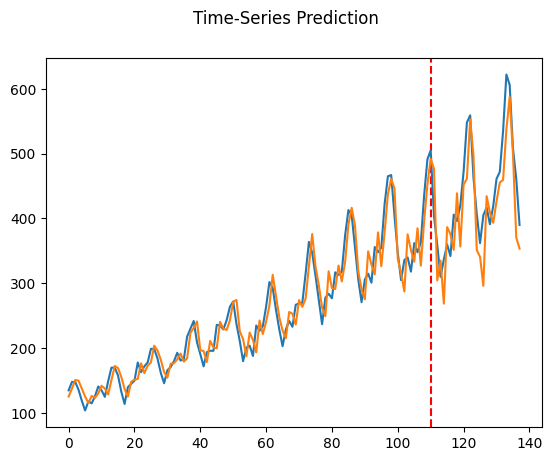

MAE (Ortalama Mutlak Hata): 24.493196487426758
MSE (Ortalama Kare Hata): 962.9151000976562
RMSE (Kök Ortalama Kare Hata): 31.030874252319336
MAPE (Ortalama Mutlak Yüzde Hata): 8.774779736995697% - pozitif


In [31]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

import numpy as np
from tabulate import tabulate

tablo_veri = np.array(dataX).reshape(len(dataX), -1)

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(dataY_plot, data_predict)

tahminler = dataY_plot
gercek_veri = data_predict

mae = mean_absolute_error(gercek_veri, tahminler)
print(f"MAE (Ortalama Mutlak Hata): {mae}")

# 2. Ortalama Kare Hata (MSE)
mse = mean_squared_error(gercek_veri, tahminler)
print(f"MSE (Ortalama Kare Hata): {mse}")

# 3. Kök Ortalama Kare Hata (RMSE)
rmse = np.sqrt(mse)
print(f"RMSE (Kök Ortalama Kare Hata): {rmse}")

# 4. Ortalama Mutlak Yüzde Hata (MAPE)
mape = np.mean(np.abs((gercek_veri - tahminler) / gercek_veri)) * 100
print(f"MAPE (Ortalama Mutlak Yüzde Hata): {mape}% - {'pozitif' if mape < 10 else 'negatif'}")
